# Machine Learning with PySpark

In [1]:
%matplotlib inline

# Filter warnings
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np
import pickle5 as pickle

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set font scale and style
plt.rcParams.update({'font.size': 15})

# Pyspark modules
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark import sql, SparkContext, SparkConf
from pyspark.sql.functions import *
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LinearSVC
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [2]:
# Import custom class
%run '../src/helper/pyspark_transfxn.py'

In [3]:
# Instantiate the class
transfxn = TransformationPipeline(label_col = 'class')

In [4]:
# Create spark session
spark = SparkSession.builder.appName("project").getOrCreate()

# Load data

In [5]:
# Load pickle file
with open("../data/collision.pkl", "rb") as file: 
    data = pickle.load(file)

# create spark dataframe
df = spark.createDataFrame(data)
df.createOrReplaceTempView("raw_table") # create table for sql query
df = df.toDF(*[c.lower() for c in df.columns]) # column names in lower case

# print data size and display sample
print("Data size:", (df.count(), len(df.columns)))
df.select(['c_year', 'p_isev', 'c_conf','v_type', 'v_year','class']).show()

Data size: (7636, 42)
+------+---------+--------------------+--------------------+------+-----+
|c_year|   p_isev|              c_conf|              v_type|v_year|class|
+------+---------+--------------------+--------------------+------+-----+
|  2017|No Injury|          Side swipe|        Road tractor|2013.0|    0|
|  2014|   Injury| Hit a moving object|  Light Duty Vehicle|2006.0|    0|
|  2017|No Injury|Right angle colli...|Other trucks and ...|2014.0|    0|
|  2012|   Injury|Any other two-veh...|  Light Duty Vehicle|1993.0|    0|
|  2015|No Injury|Hit a stationary ...|  Light Duty Vehicle|2006.0|    0|
|  1999|No Injury|Left turn across ...|  Light Duty Vehicle|1997.0|    0|
|  2000|   Injury|  left turn conflict|  Light Duty Vehicle|1990.0|    0|
|  2013|   Injury|Right angle colli...|  Light Duty Vehicle|2005.0|    0|
|  2007|   Injury|Any other single-...|  Light Duty Vehicle|2001.0|    0|
|  2014|No Injury|Right angle colli...|Motorcycle and moped|2013.0|    0|
|  2009|   Injur

In [6]:
df.printSchema()

root
 |-- c_year: long (nullable = true)
 |-- c_mnth: string (nullable = true)
 |-- c_wday: string (nullable = true)
 |-- c_hour: double (nullable = true)
 |-- class: long (nullable = true)
 |-- c_vehs: double (nullable = true)
 |-- c_conf: string (nullable = true)
 |-- c_rcfg: string (nullable = true)
 |-- c_wthr: string (nullable = true)
 |-- c_rsur: string (nullable = true)
 |-- c_raln: string (nullable = true)
 |-- c_traf: string (nullable = true)
 |-- v_id: double (nullable = true)
 |-- v_type: string (nullable = true)
 |-- v_year: double (nullable = true)
 |-- p_id: double (nullable = true)
 |-- p_sex: string (nullable = true)
 |-- p_age: double (nullable = true)
 |-- p_psn: string (nullable = true)
 |-- p_isev: string (nullable = true)
 |-- p_safe: string (nullable = true)
 |-- p_user: string (nullable = true)
 |-- c_case: long (nullable = true)
 |-- wday_ct: long (nullable = true)
 |-- mnth_ct: long (nullable = true)
 |-- year_ct: long (nullable = true)
 |-- hour_ct: long (null

# Class distribution

In [7]:
query = """ 
select 
    class, 
    count(*) as count,
    round(count(*)*100/(select count(*) from raw_table),2) as percentage
from raw_table
group by 1
order by 1
"""
spark.sql(query).show()

+-----+-----+----------+
|class|count|percentage|
+-----+-----+----------+
|    0| 7513|     98.39|
|    1|  123|      1.61|
+-----+-----+----------+



# Convert numerical variables to double schema

In [8]:
dont_cols =  [field for (field, dataType) in df.dtypes if dataType == "string"]
df = transfxn.df_to_numeric(df, dont_cols)

# Create a test set
We split the data into 50 $\%$ training set, 30 $\%$ validation set,  and 20 $\%$ test set


In [9]:
cols_to_drop = ('c_case', 'p_id', 'v_id', 'c_traf',
                'v_type_ind', 'p_psn_ind', 'c_wthr_ind', 
                'c_raln_ind', 'c_rsur_ind', 'c_traf_ind',
                'conf_per_day', 'conf_per_hour', 'c_rcfg_ind'
)
df = df.drop(*cols_to_drop) # drop selected columns

In [10]:
trainDF, validDF, testDF = df.randomSplit([.5, 0.3, .2], seed=42)

In [11]:
print('Training set size:', (trainDF.count(), len(trainDF.columns)))
print('Validation set size:', (validDF.count(), len(validDF.columns)))
print('Test set size:', (testDF.count(), len(testDF.columns)))

Training set size: (3847, 29)
Validation set size: (2315, 29)
Test set size: (1474, 29)


# Transformation Pipelines

In [12]:
# Transform and scale data
assembler, trainDF_scaled, validDF_scaled, testDF_scaled = transfxn.preprocessing(trainDF,validDF, testDF)

In [13]:
cols = ['features', 'class','c_year', 'p_isev']
trainDF_scaled.select(cols).show(5)

+--------------------+-----+------+------+
|            features|class|c_year|p_isev|
+--------------------+-----+------+------+
|(103,[9,12,21,34,...|  0.0|1999.0|Injury|
|(103,[9,13,30,35,...|  0.0|1999.0|Injury|
|(103,[1,16,30,35,...|  0.0|1999.0|Injury|
|(103,[1,12,30,35,...|  0.0|1999.0|Injury|
|(103,[1,21,34,41,...|  0.0|1999.0|Injury|
+--------------------+-----+------+------+
only showing top 5 rows



# A. Linear Support Vector Machine

In [14]:
# Train a linear svm model.
svm = LinearSVC(labelCol = "class", featuresCol = "features", maxIter = 100, regParam=1)

# Fit the training set 
svm_model = svm.fit(trainDF_scaled)

# Make predictions on the validation set
svm_val_pred = svm_model.transform(validDF_scaled)

# Select example rows to display
cols = ["features", "class", "rawPrediction", "prediction"]
svm_val_pred.select(cols).show(5)

+--------------------+-----+--------------------+----------+
|            features|class|       rawPrediction|prediction|
+--------------------+-----+--------------------+----------+
|(103,[9,16,17,35,...|  1.0|[1.02232456027259...|       0.0|
|(103,[9,12,29,34,...|  0.0|[1.00713999333102...|       0.0|
|(103,[9,12,17,34,...|  0.0|[1.00753671296754...|       0.0|
|(103,[9,12,24,35,...|  0.0|[1.01714088267821...|       0.0|
|(103,[9,15,17,34,...|  0.0|[1.01515021943893...|       0.0|
+--------------------+-----+--------------------+----------+
only showing top 5 rows



## A-1: Performance metrics on the validation set

In [15]:
transfxn.eval_metrics(svm_val_pred, model_nm = 'Linear Support Vector Machine')

Performance metrics for Linear Support Vector Machine
------------------------------------------------------------
AUROC: 0.719
AUPRC: 0.380


In [16]:
# Predicted classes
svm_val_pred.groupBy('prediction')\
    .count()\
    .sort(desc("count"))\
    .show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 2315|
+----------+-----+



# B. Random Forest Classifier

In [17]:
# Train a random forest classifier.
rf = RandomForestClassifier(labelCol = "class", featuresCol = "features",  numTrees = 1000,  maxDepth = 5
)

# Fit the training set 
rf_model = rf.fit(trainDF_scaled)

# Make predictions on the validation set
rf_val_pred = rf_model.transform(validDF_scaled)

# Select example rows to display
cols = ["features", "class", "rawPrediction", "prediction", 'probability']
rf_val_pred.select(cols).show(5)

+--------------------+-----+--------------------+----------+--------------------+
|            features|class|       rawPrediction|prediction|         probability|
+--------------------+-----+--------------------+----------+--------------------+
|(103,[9,16,17,35,...|  1.0|[990.073696544571...|       0.0|[0.99007369654457...|
|(103,[9,12,29,34,...|  0.0|[992.063492876730...|       0.0|[0.99206349287673...|
|(103,[9,12,17,34,...|  0.0|[993.595472463815...|       0.0|[0.99359547246381...|
|(103,[9,12,24,35,...|  0.0|[987.791007634066...|       0.0|[0.98779100763406...|
|(103,[9,15,17,34,...|  0.0|[982.393031816699...|       0.0|[0.98239303181669...|
+--------------------+-----+--------------------+----------+--------------------+
only showing top 5 rows



## B-1: Performance metrics on the validation set

In [18]:
transfxn.eval_metrics(rf_val_pred, model_nm = 'Random Forest Classifier')

Performance metrics for Random Forest Classifier
------------------------------------------------------------
AUROC: 0.856
AUPRC: 0.465


In [19]:
# Predicted classes
rf_val_pred.groupBy('prediction')\
    .count()\
    .sort(desc("count"))\
    .show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 2302|
|       1.0|   13|
+----------+-----+



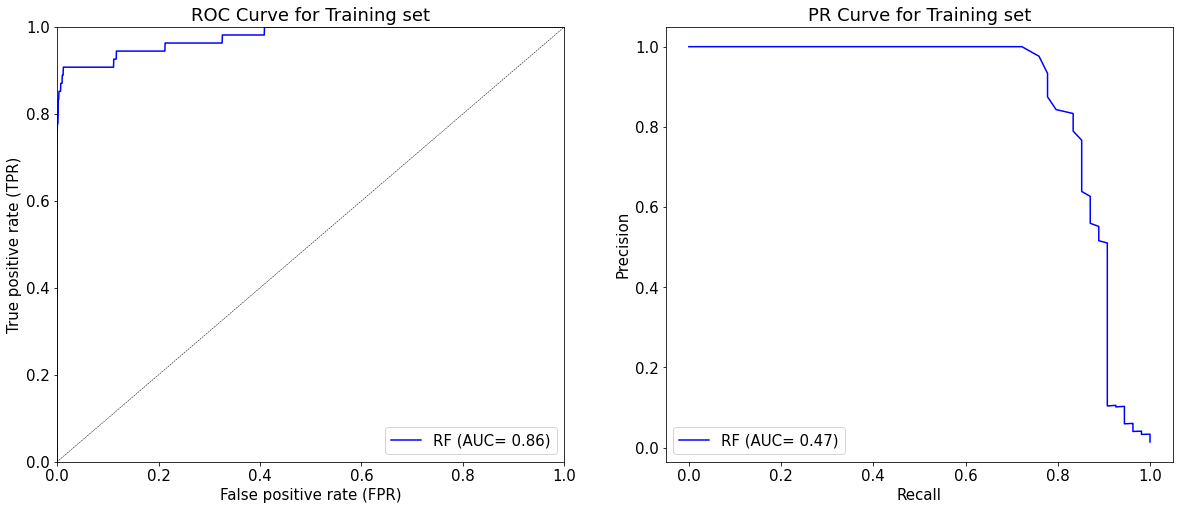

In [20]:
plt.figure(figsize = (20,8))
transfxn.plot_roc_pr_curves(rf_model, rf_val_pred, title = 'Training set', 
                            label= 'RF (AUC= %0.2f)')

## B-2. Feature Importances

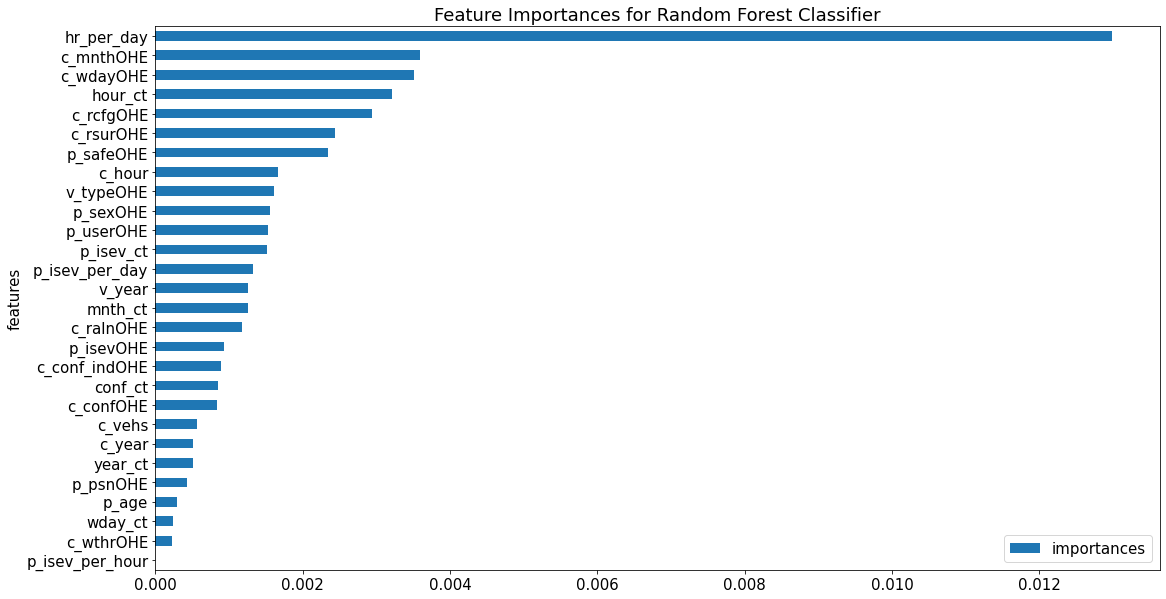

In [21]:
# Feature importances
feature_imp = pd.DataFrame(
      list(zip(assembler.getInputCols(), rf_model.featureImportances)), 
      columns=["features", "importances"]
      )

# Plot bar chart
feature_imp.sort_values('importances', ascending = True, inplace = True)
feature_imp.set_index('features', inplace = True)
feature_imp.plot(kind='barh', figsize = (18,10))
plt.title('Feature Importances for Random Forest Classifier')
plt.show()

## B-3. Hyperparameter tuning
We now optimize the AUPRC of Random forest regressor using grid search and 5-fold cross-validation

In [22]:
paramGrid = ParamGridBuilder()\
            .addGrid(rf.maxDepth, [4,6,10])\
            .addGrid(rf.maxBins, [20,60])\
            .build()

evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', 
                                         labelCol= 'class', metricName="areaUnderPR"
                                         )
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator,
 numFolds=5, seed=42)

In [ ]:
cv_model = cv.fit(trainDF_scaled) # Fit the training set
rf_cv_pred = cv_model.transform(validDF_scaled) # Make predictions on the validation set

In [24]:
list(zip(cv_model.getEstimatorParamMaps(), cv_model.avgMetrics))

[({Param(parent='RandomForestClassifier_e57eabf2c4e0', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 4,
   Param(parent='RandomForestClassifier_e57eabf2c4e0', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 20},
  0.5110834453723128),
 ({Param(parent='RandomForestClassifier_e57eabf2c4e0', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 4,
   Param(parent='RandomForestClassifier_e57eabf2c4e0', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 60},
  0.5132826878130688),
 ({Param(parent='RandomForestClassifier_e57eabf2c4e0', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf no

## B-4. Performance metrics on the test set

In [26]:
rf_test_pred = cv_model.transform(testDF_scaled)
transfxn.eval_metrics(rf_test_pred, model_nm = 'Random Forest Classifier')

Performance metrics for Random Forest Classifier
------------------------------------------------------------
AUROC: 0.832
AUPRC: 0.616


# C. Gradient-Boosted Tree Classifier

In [27]:
# Train a Gradient-boosted tree classifier model
gbt = GBTClassifier(labelCol = "class", featuresCol = "features", maxDepth = 5, maxIter= 100)

# Fit the training set 
gbt_model = gbt.fit(trainDF_scaled)

# Make predictions on the validation set
gbt_val_pred = gbt_model.transform(validDF_scaled)

# Select example rows to display
cols = ["features", "class", "rawPrediction", "prediction", 'probability']
gbt_val_pred.select(cols).show(5)

+--------------------+-----+--------------------+----------+--------------------+
|            features|class|       rawPrediction|prediction|         probability|
+--------------------+-----+--------------------+----------+--------------------+
|(103,[9,16,17,35,...|  1.0|[2.21394643418366...|       0.0|[0.98820125105737...|
|(103,[9,12,29,34,...|  0.0|[2.18837724231053...|       0.0|[0.98758987072282...|
|(103,[9,12,17,34,...|  0.0|[2.19651609043163...|       0.0|[0.98778779681032...|
|(103,[9,12,24,35,...|  0.0|[2.05710502492267...|       0.0|[0.98392382392008...|
|(103,[9,15,17,34,...|  0.0|[2.21266019075472...|       0.0|[0.98817121934789...|
+--------------------+-----+--------------------+----------+--------------------+
only showing top 5 rows



## C-1. Performance metrics on the validation set

In [28]:
transfxn.eval_metrics(gbt_val_pred, model_nm = 'GBT Classifier')

Performance metrics for GBT Classifier
------------------------------------------------------------
AUROC: 0.737
AUPRC: 0.401


## C-2. Feature Importances

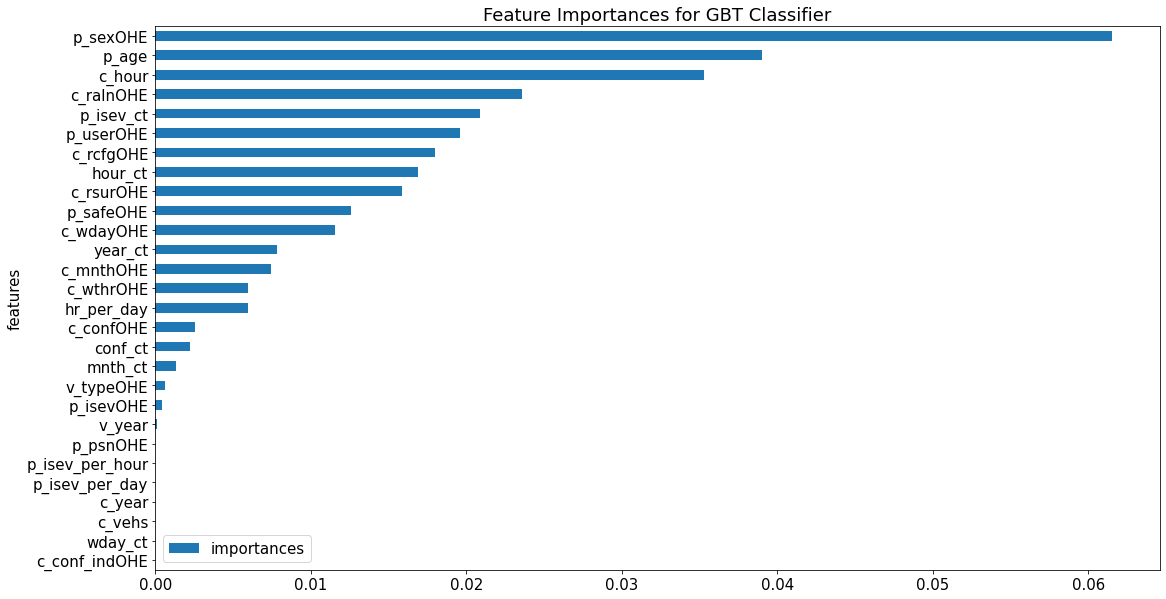

In [29]:
# Feature importances
feature_imp = pd.DataFrame(
      list(zip(assembler.getInputCols(), gbt_model.featureImportances)), 
      columns=["features", "importances"]
      )

# Plot bar chart
feature_imp.sort_values('importances', ascending = True, inplace = True)
feature_imp.set_index('features', inplace = True)
feature_imp.plot(kind='barh', figsize = (18,10))
plt.title('Feature Importances for GBT Classifier')
plt.show()

## C-3. Performance metrics on the test set

In [30]:
gbt_test_pred = gbt_model.transform(testDF_scaled)
transfxn.eval_metrics(gbt_test_pred, model_nm = 'GBT Classifier')

Performance metrics for GBT Classifier
------------------------------------------------------------
AUROC: 0.833
AUPRC: 0.593
